In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [4]:
data = pd.read_csv('amazon_alexa.tsv',delimiter='\t',quoting=3)
data.dropna(inplace=True)

In [5]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [6]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [7]:
example = data['verified_reviews'][51]
print(example)

"I'm still learning how to use it, but so far my Echo is great! The sound is actually much better than I was expecting."


In [8]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0031059375, 'roberta_neu': 0.013506233, 'roberta_pos': 0.9833878}


In [9]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt', truncation=True, max_length=512)
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict


In [10]:
polarity_scores_roberta(example)

{'roberta_neg': 0.0031059375,
 'roberta_neu': 0.013506233,
 'roberta_pos': 0.9833878}

In [ ]:
#VADER
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [12]:
# Check for NaNs or non-strings
data['verified_reviews'].apply(type).value_counts()

verified_reviews
<class 'str'>    3149
Name: count, dtype: int64

In [13]:
sentiment_scores = data['verified_reviews'].apply(lambda x: sia.polarity_scores(x)).apply(pd.Series)
data = pd.concat([data, sentiment_scores], axis=1)

roberta_scores = data['verified_reviews'].apply(lambda x: polarity_scores_roberta(x)).apply(pd.Series)
data = pd.concat([data, roberta_scores], axis=1)


data

,rating,date,variation,verified_reviews,feedback,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,0.000,0.308,0.692,0.6696,0.002404,0.014571,0.983025
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,0.000,0.193,0.807,0.6360,0.003420,0.016371,0.980209
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,0.102,0.784,0.114,-0.1280,0.164042,0.415865,0.420093
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,0.000,0.670,0.330,0.8957,0.001857,0.021638,0.976505
4,5,31-Jul-18,Charcoal Fabric,Music,1,0.000,1.000,0.000,0.0000,0.119844,0.696196,0.183960
...,...,...,...,...,...,...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1,0.000,0.620,0.380,0.6467,0.005170,0.078889,0.915941
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1,0.000,1.000,0.000,0.0000,0.058853,0.408031,0.533116
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1,0.028,0.738,0.234,0.9485,0.002146,0.011489,0.986366
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1,0.087,0.827,0.087,0.0008,0.472854,0.439059,0.088087


In [14]:
# VADER sentiment label based on compound score
def vader_sentiment(row):
    if row['compound'] >= 0.05:
        return 'Positive'
    elif row['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# RoBERTa sentiment label based on highest score
def roberta_sentiment(row):
    scores = {
        'Negative': row['roberta_neg'],
        'Neutral': row['roberta_neu'],
        'Positive': row['roberta_pos']
    }
    return max(scores, key=scores.get)

# Apply both
data['vader_sentiment'] = data.apply(vader_sentiment, axis=1)
data['roberta_sentiment'] = data.apply(roberta_sentiment, axis=1)

# Display just the two new columns
data


,rating,date,variation,verified_reviews,feedback,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,vader_sentiment,roberta_sentiment
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,0.000,0.308,0.692,0.6696,0.002404,0.014571,0.983025,Positive,Positive
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,0.000,0.193,0.807,0.6360,0.003420,0.016371,0.980209,Positive,Positive
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,0.102,0.784,0.114,-0.1280,0.164042,0.415865,0.420093,Negative,Positive
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,0.000,0.670,0.330,0.8957,0.001857,0.021638,0.976505,Positive,Positive
4,5,31-Jul-18,Charcoal Fabric,Music,1,0.000,1.000,0.000,0.0000,0.119844,0.696196,0.183960,Neutral,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1,0.000,0.620,0.380,0.6467,0.005170,0.078889,0.915941,Positive,Positive
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1,0.000,1.000,0.000,0.0000,0.058853,0.408031,0.533116,Neutral,Positive
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1,0.028,0.738,0.234,0.9485,0.002146,0.011489,0.986366,Positive,Positive
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1,0.087,0.827,0.087,0.0008,0.472854,0.439059,0.088087,Neutral,Negative


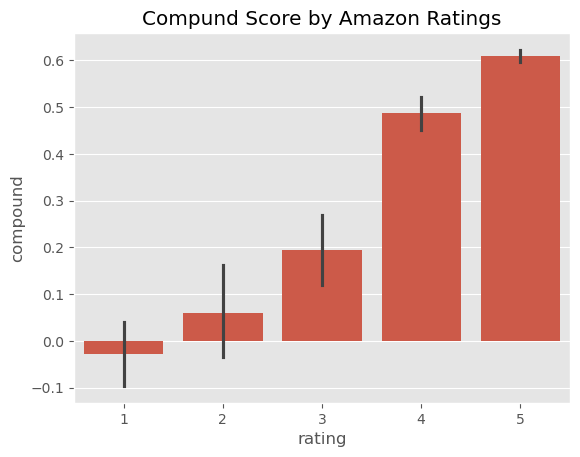

In [15]:
ax = sns.barplot(data=data, x='rating', y='compound')
ax.set_title('Compund Score by Amazon Ratings')
plt.show()